<div style ="border: blue solid 5px; font-family: Agency FB;	"><center>
<a href="#" ></a> 
    <h2> <font color="blue">MODELISATION RATIO </font> </h2> 
<a href="#" ></a>     
</center>
</div>

Ce note-book porte trois principaux points: la création des variables ratios avec ses hypothèses, la modélisation explicative et les modèles prédictifs réalisés.

## Table des matières

* [1. Préliminaire](#1-préliminaire)
* [2. Création des variables ratio](#2-création-des-variables-ratio)
* [3. Modélisation explicative](#3-modélisation-ratio)
    * [3.1 Modèle 1](#modèle-explicatif-1)
    * [3.2 Modèle 2](#modèle-explicatif-2)
    * [3.3 Modèle 3](#modèle-explicatif-3)
    * [3.4 Modèle 4](#modèle-explicatif-4)
* [4. Modélisation prédictive](#4-modélisation-prédictive)
    * [4.1 Repartition de l'échantillon](#création-déchantillons-dapprentissage-et-test)
    * [4.2 Evaluation du modèle](#evaluation-des-différents-modèles)
    * [4.3 Choix du meilleur modèlle](#choix-de-meilleurs-modèles)

# 1. Préliminaire

In [135]:
## Importation des packages nécessaires
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline 
from matplotlib import rc

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 14,
          'legend.fontsize':12,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'text.usetex': True,
          'figure.figsize': (14, 8)
          }
plt.rcParams.update(params)

import seaborn as sns
import altair as alt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

In [136]:
# Définition du repertoire de travail
os.chdir("D:/ENSAI/2A/Projet Statistique/projet-risque-de-transition/")  # Mettez ic le repertoire de vos bases

In [137]:
# Importation de la base ASDES
base_asdes = pd.read_csv("bdd/Base_finale/ASDES_vf.csv")

### Jointure
On fait d'abord la jointure de l base ADEME+SIREN+DIANE avec la base filière pour les TPE/PME. La variable de fusion est une "concatenation" des variables reporting year et le code APE au niveau 1.

In [138]:
liste = [col for col in base_asdes if\
    ('_secteur' in col) & (col != 'Activite_secteur')]
base_asdes.drop(liste,axis=1, inplace=True)

secteur_tpe_pme = pd.read_csv("bdd/esane/base_secteur_tpe_pme_vf.csv")

## Creation de la variable de fusion: secteur_year
base_asdes['secteur_year'] = base_asdes.APE_niv_1.apply(str) +\
    base_asdes.reporting_year.apply(str)
secteur_tpe_pme['secteur_year'] = secteur_tpe_pme.\
    SecteurDActivite_secteur.apply(str) + secteur_tpe_pme\
        .annee_secteur.apply(str)
    
### Fusion de la base filière
vf = base_asdes.merge(secteur_tpe_pme, on ='secteur_year',
how='left')

## Taux de perdition de la fusion Esane - Affectation
taux_perte = np.sum(vf['secteur_secteur'].isna())/base_asdes.shape[0]*100
print("On obtient un taux de perdition de ", round(taux_perte, 3), "%")

base_asdes = vf.copy()

On obtient un taux de perdition de  0.57 %


Après fusion, on 0,57% d'informations. Il s'agit de l'année de reporting 2021 et la filière O (Administration publique) qui n'est pas disponible dans les données ESANE.

In [139]:
base_asdes[(base_asdes.CA_exportation_secteur.isna())][['SecteurDActivite_secteur','annee_secteur','secteur_secteur','reporting_year','APE_niv_1']]


,SecteurDActivite_secteur,annee_secteur,secteur_secteur,reporting_year,APE_niv_1
45,NaN,NaN,NaN,2021,C
87,NaN,NaN,NaN,2021,J
440,NaN,NaN,NaN,2021,J
532,NaN,NaN,NaN,2021,J
549,NaN,NaN,NaN,2021,M
940,NaN,NaN,NaN,2021,J
1197,NaN,NaN,NaN,2019,O


Nous allons faire une simple imputation de ces perditions.

In [140]:
## Recuperation des noms de variables quantitatives
list_temp = ['Activite_secteur',
 'annee_secteur','description_ape_secteur','secteur_secteur', 'SecteurDActivite_secteur']
list_var_a_imputee = [col for col in base_asdes if ('_secteur' in col) & (col not in list_temp)]
list_var_a_imputee

['NbEntrp_secteur',
 'FraisPersonnel_secteur',
 'Salaries_tps_plein_secteur',
 'CA_exportation_secteur',
 'CA_hors_taxe_secteur',
 'EBE_secteur',
 'VA_et_autres_prdts_charges_secteur',
 'ResultatNetComptable_secteur',
 'CapaciteAutofinancement_secteur',
 'ResultatCourantAvantImpots_secteur',
 'InvestCorporelsBrutsHorsApports_secteur',
 'CO2_secteur',
 'CO2e_secteur',
 'CH4_secteur',
 'N2O_secteur',
 'HFC_secteur',
 'PFC_secteur',
 'SF6_secteur',
 'NF3_secteur',
 'Gaz_fluores_secteur',
 'eges_secteur']

In [141]:
## Imputation de taux de perdition

imputer = SimpleImputer(strategy='mean')
donnees = imputer.fit_transform(base_asdes[list_var_a_imputee])
base_asdes.drop(list_var_a_imputee, axis=1, inplace=True)
base_asdes[list_var_a_imputee] = donnees

In [142]:
## Imputation des variables de fusion
base_asdes["annee_secteur"] = base_asdes["reporting_year"]
base_asdes["SecteurDActivite_secteur"] = base_asdes["APE_niv_1"]

### Statistique: repartition de l'échantillon par filière et par catégorie

Text(0, 0.5, "Nombre d'entreprises")

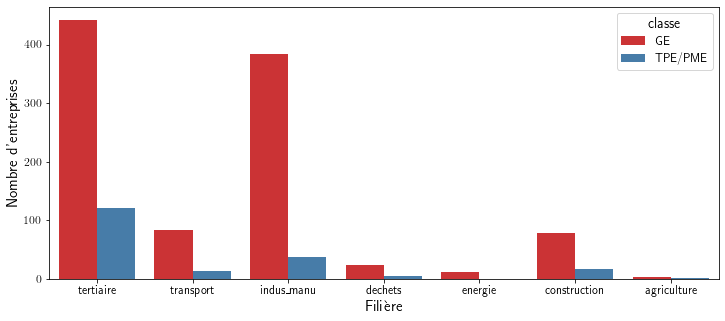

In [143]:

plt.figure(figsize=(12,5))
sns.countplot(x="secteur_secteur",hue="classe", data=base_asdes, palette="Set1",)

plt.xlabel('Filière', fontsize = 15)
plt.ylabel('Nombre d\'entreprises', fontsize = 15)

In [144]:
## Visualisation
pd.crosstab(base_asdes.SecteurDActivite_secteur,
base_asdes.secteur_secteur)

secteur_secteur,agriculture,construction,dechets,energie,indus_manu,tertiaire,transport
SecteurDActivite_secteur,,,,,,,
A,4,0,0,0,0,0,0
B,0,0,0,2,0,0,0
C,0,0,0,0,422,0,0
D,0,0,0,9,0,0,0
E,0,0,28,0,0,0,0
F,0,96,0,0,0,0,0
G,0,0,0,0,0,184,0
H,0,0,0,0,0,0,98
I,0,0,0,0,0,30,0


On remarque que les perditions après fusion correspondent au secteur d'émissions Tertiaire. Donc on remplace les missing par la modalité tertiaire pour la variable précisant les secteurs d'émissions.

In [145]:
base_asdes.secteur_secteur.replace(np.nan,'tertiaire', inplace=True)

# 2. Création des variables ratio

Dans la suite du code, nous allons calculer les variables ratio entreprise-filière avant la modélisation. Ainsi, les informations financières que nous disposons au niveau filière (Esane) concernent les TPE/PME. Mais les émissions de GES au niveau filière concernent toutes les catégories d'entreprises. Il va falloir donc calculer les émissions de GES pour les TPE/PME uniquement au niveau filière. <p>
Pour cela, nous utilisons les émissions du scope 1 et 2 de la base ADEME. On a la proposition suivante: <p>
$Y_{SecteurA, TPE/PME} = \hat{\alpha}_{SecteurA,TPE/PME} * Y_{SecteurA}$ <p> où le $\hat{\alpha}_{SecteurA,TPE/PME}$ est la part des émissions du TPE/PME dans le total des émissions du secteur A estimée avec les émissions du scope 1 & 2 d'Ademe.

In [146]:
## calul du total des scopes
base_asdes = base_asdes.assign(total_ges = base_asdes.total_scope_1 + base_asdes.total_scope_2)

In [147]:
#base_asdes['secteur_year'] = base_asdes.APE_niv_1.apply(str) + base_asdes.reporting_year.apply(str)

### Calcul de $\alpha$
On calcule d'abord les totaux des émissions Filière et Filière TPE/PME

In [148]:
## Somme des émissions par filière
temp = base_asdes.groupby('secteur_secteur').sum()[['eges_secteur', 'total_ges']]
temp['secteur_secteur'] = temp.index
temp.reset_index(inplace = True, drop = True)

# Changer les noms des nouveaux totaux
dic = {'eges_secteur':'eges_secteur_global', 'total_ges':'total_ges_global'}
temp.rename(columns=dic, inplace=True)

# Fusion des totaux avec la base initiale 
base = base_asdes.merge(temp, on='secteur_secteur', how='left')

In [149]:
## Somme des émissions par filière TPE/PME
temp = base.groupby(['secteur_secteur','classe']).sum()[['eges_secteur','total_ges']]
temp['secteur_secteur'] = temp.index.get_level_values(0)
temp['classe'] = temp.index.get_level_values(1)
temp.reset_index(inplace = True, drop = True)

# Changer les noms des nouveaux totaux
dic = {'eges_secteur':'eges_secteur_tpe_pme', 'total_ges':'total_ges_tpe_pme'}
temp.rename(columns=dic, inplace=True)

# Fusion des Totaux TPE/PME avec la base initiale
base = base.merge(temp, on=['secteur_secteur','classe'], how='left')

`eges_secteur_global` et `eges_secteur_tpe_pme` n'interviennent pas dans le calcul des ratios, on peut donc les supprimer. Ils ont juste été calculer pour permettre à la méthode `groupby` de retourner la structure d'un dataframe. 

In [150]:
base.drop(['eges_secteur_global','eges_secteur_tpe_pme'],
axis = 1, inplace = True)

On calcule ainsi le $\alpha$ que l'on appelle `taux` dans le dataframe.

In [151]:
# Estimation de la part des TPE/PME dans l'échantillon
base = base.assign(taux = base.total_ges_tpe_pme/base.total_ges_global)

### Peu de variables au niveau filière
Avant de calculer les ratios, nous allons estimer les totaux au niveau filière de quelques variables (comme le bilan). En effet, avec les données Esane nous disposons de peu de variables financières. Nous allons donc les enrichir avec des estimations des totaux.

In [152]:
# Moyenne selon le secteur et l'annee de reporting
vf_gr = base.groupby('secteur_year').mean()[['TotalAsset','NbEntrp_secteur','Average_number_of_employees', 'VAT']]
vf_gr['secteur_year'] = vf_gr.index
vf_gr.reset_index(inplace = True, drop = True)

dic = {'TotalAsset':'TotalAsset_secteur', 'NbEntrp_secteur':'NbEntreprise_secteur',
'Average_number_of_employees':'NbEmploye_secteur', 'VAT':'VAT_s'}
vf_gr.rename(columns=dic, inplace=True)

# Fusion des moyennes calculées dans la base complète 
base = base.merge(vf_gr, on='secteur_year', how='left')

In [153]:
# Copie de la base pour garder la précision ASDES (Ademe+Siren+Diane+Esane+Secten)
base_asdes = base.copy()

Ainsi, pour le calcul de tous les ratios, on applique la formule suivante:

  $ratio_{tpe\_pme} = \frac{var_{entrp}}{var_{filiere}} * \frac{Var\_filiere\_tpe\_pme\_estimee}{Var\_filiere\_estimee} =
  \frac{var_{entrp}}{var_{filiere}} * \textit{proportion des tpe\_pme dans la filiere}$

On identifie les correspondances de chaque variable filière à une variable caractérisque de Diane.

In [90]:
# ratio pour Chiffre d'affaires net
vf = base_asdes.assign(CA_rate = base_asdes['NetTurnover']*base_asdes['taux']/base_asdes['CA_hors_taxe_secteur']/1000000)

# Ratio pour la valeur ajoutée
vf = vf.assign(VA_rate = vf['Added_value']*vf['taux']/vf['VA_et_autres_prdts_charges_secteur']/1000000)

# Ratio pour le chiffre d'affaires à l'exportation
vf =vf.assign(CA_export_rate = vf['Net_turnover_related_to_exports']*vf['taux']/vf['CA_exportation_secteur']/1000000)

# Ratio pour Excédent brut d'exploitation: (Equivalent dans la base diane est TOTAL_OPERATING_EXPENSES_4___II, a reverifier)
vf = vf.assign(EBE_rate = vf['TOTAL_OPERATING_EXPENSES_4___II']/vf['taux']/vf['EBE_secteur']/1000000)

# Ratio pour le bilan: pour la valeur au niveau filière, il est estimé avec les données Diane
vf = vf.assign(Bilan_secteur = vf['TotalAsset_secteur']*vf['NbEntreprise_secteur'])
vf = vf.assign(Bilan_rate = vf['TotalAsset']*vf['taux']/vf['Bilan_secteur'])

# Ratio pour la TVA: pour la valeur au niveau filière, elle est aussi estimée avec les données Diane
vf = vf.assign(VAT_secteur = vf['VAT_s']*vf['NbEntreprise_secteur'])
vf = vf.assign(VAT_rate = vf['VAT']*vf['taux']/vf['VAT_secteur'])

# Ratio pour le nombre d'employés
vf = vf.assign(NbEmploye_rate = vf['Average_number_of_employees']*vf['taux']/vf['Salaries_tps_plein_secteur'])

# Ratio pour le salaire (rémunération salariales)
vf = vf.assign(Salaire_rate = vf['Wages_and_salaries']*vf['taux']/vf['FraisPersonnel_secteur']/1000000)

# Ratio pour investissement: Variables indisponibles dans diane??
vf = vf.assign(invest_rate = vf['Investment_grants']*vf['taux']/vf['InvestCorporelsBrutsHorsApports_secteur']/1000000)

# Ratio des émissions GES (pour le total)
# création de la variable total de scopes
base_asdes = vf.assign(ges_rate= vf['total_ges']*vf['taux']/vf['eges_secteur']/1000000) # le 1 000 000, c'est pour convertir le Mt en t

## DONNEES POUR LES TPE/PME

Après avoir calculé les variables ratios possibles, on s'interesse maintenant uniquement aux TPE/PME et aux variables ratios.

In [91]:
## On garde les TPE/PME et les variables ratios calculées 
liste_var = [col for col in base_asdes if ('_rate' in col) |
 (col in ['reporting_year', 'secteur_secteur', 'eges_secteur'])]
select_tpe = (base_asdes['classe'] != 'GE')
base_finale = base_asdes.loc[select_tpe, liste_var]

### Enregistrement de la base ratio
Cette base comporte uniquement des variables ratios et trois autres variables pertinentes pour le top-down: année de reporting, la filière et les émissions de GES du secteur.

In [92]:
base_finale.to_csv("bdd/Base_finale/base_ratio.csv", index=False)

In [93]:
## On supprime la variable eges_secteur
base_finale.drop('eges_secteur', axis=1, inplace=True)

In [94]:
## Individus et variables
base_finale.shape

(203, 12)

# 3. Modélisation Ratio

## Préliminaire
Importation des librairies nécessaires à la modélisation

In [95]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_validate, cross_val_predict
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.utils import shuffle
import time

# Metric d'evaluation
from sklearn.metrics import mean_squared_error

from statsmodels import stats

from statsmodels.nonparametric.smoothers_lowess import lowess # pour le lissage
from statsmodels.stats.outliers_influence import OLSInfluence # pour récupérer les résidus studentisés

## Sélection des variables

<AxesSubplot:xlabel='secteur_secteur', ylabel='ges_rate'>

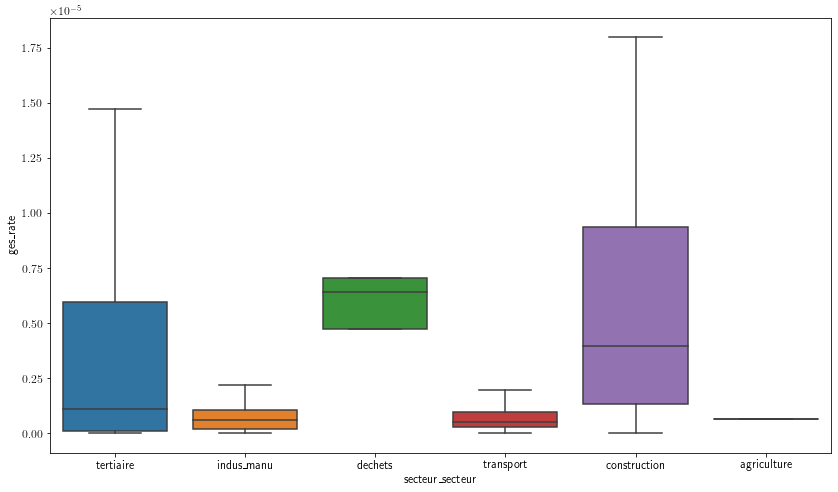

In [96]:
## Boxplot: pour identifier les secteurs qui ont la même distribution
sns.boxplot(x = "secteur_secteur", y = "ges_rate", data=base_finale, showfliers = False)

In [97]:
# création des variables binaires pour les secteurs
# Meilleur division de filière:
base_finale[["Autre","construction","dechets",
"indus_manu",
"tertiaire",
"transport"]] = pd.get_dummies(base_finale["secteur_secteur"])

## On supprime la variable Autre pour éviter le problème d'identifiabilité des modèles
## VAT_rate contient trop de valeurs, donc est supprimée
base_finale.drop(['Autre','VAT_rate',"secteur_secteur", "reporting_year"], axis=1, inplace= True)

In [98]:
# Valeurs manquantes
base_finale.isna().sum()

CA_rate           0
VA_rate           0
CA_export_rate    0
EBE_rate          0
Bilan_rate        0
NbEmploye_rate    0
Salaire_rate      0
invest_rate       0
ges_rate          0
construction      0
dechets           0
indus_manu        0
tertiaire         0
transport         0
dtype: int64

### Etude de corrélation

In [99]:
corr = base_finale.corr(method=
'spearman').style.format("{:.2}").background_gradient(cmap=
plt.get_cmap('coolwarm'))
corr.to_excel("matrice_corr_rate.xlsx", index=False)
corr

,CA_rate,VA_rate,CA_export_rate,EBE_rate,Bilan_rate,NbEmploye_rate,Salaire_rate,invest_rate,ges_rate,construction,dechets,indus_manu,tertiaire,transport
CA_rate,1.0,0.87,0.25,0.89,0.71,0.46,0.89,0.23,0.11,-0.055,0.26,-0.075,-0.12,0.21
VA_rate,0.87,1.0,0.14,0.81,0.73,0.54,0.86,0.24,0.12,-0.036,0.27,-0.063,-0.18,0.28
CA_export_rate,0.25,0.14,1.0,0.3,0.18,-0.18,0.2,0.088,-0.26,-0.063,-0.17,0.17,-0.059,-0.0058
EBE_rate,0.89,0.81,0.3,1.0,0.66,0.39,0.8,0.25,0.083,0.083,0.26,0.069,-0.29,0.16
Bilan_rate,0.71,0.73,0.18,0.66,1.0,0.31,0.68,0.21,0.013,-0.23,0.27,0.054,-0.14,0.24
NbEmploye_rate,0.46,0.54,-0.18,0.39,0.31,1.0,0.52,0.099,0.51,-0.011,0.27,-0.016,-0.18,0.18
Salaire_rate,0.89,0.86,0.2,0.8,0.68,0.52,1.0,0.21,0.11,-0.056,0.27,-0.18,-0.074,0.28
invest_rate,0.23,0.24,0.088,0.25,0.21,0.099,0.21,1.0,-0.012,-0.11,0.26,0.13,-0.14,0.018
ges_rate,0.11,0.12,-0.26,0.083,0.013,0.51,0.11,-0.012,1.0,0.19,0.15,-0.17,0.036,-0.1
construction,-0.055,-0.036,-0.063,0.083,-0.23,-0.011,-0.056,-0.11,0.19,1.0,-0.048,-0.15,-0.39,-0.082


Nous identifions six (6) variables explicatives pertinentes :
<li> Chiffre d'affaires
<li> Chiffre d'affaires à l'exportation
<li> Nombre d'employés
<li> Appartenance à la filière construction
<li> Appartenance à la filière déchets
<li> Appartenance à la filière industrie manufacturière

In [100]:
## Liste des variables sélectionnées pour le modèle par analyse de la corrélation
variables_lineare = ['CA_rate','NbEmploye_rate','CA_export_rate','construction', 'dechets','indus_manu']
variable_expliquee = 'ges_rate'

### Sélection pas à pas

Nous avons mis en place un algorithme de sélection des variables selon AIC ou BIC.

In [101]:
from selection_forward import forward_selected
liste = [col for col in base_finale if '_rate' in col]
print(forward_selected(base_finale[liste], 'ges_rate', 'aic').model.formula)
print(forward_selected(base_finale[liste], 'ges_rate', 'bic').model.formula)

ges_rate ~ 1 + EBE_rate+VA_rate
ges_rate ~ 1 + EBE_rate


In [102]:
## Variables sélectionnées par AIC sur les variables ratios uniquement
variables_lineare_aic_rate = ['invest_rate','Bilan_rate','VA_rate','CA_rate']

## Variables sélectionnées par AIC sur les variables ratios uniquement
variables_lineare_aic = ['CA_rate','Bilan_rate','EBE_rate','construction', 'dechets','tertiaire']
variable_expliquee = 'ges_rate'

## Transformation log

Nous créons une base base logarithmique en transformant toutes les variables en log.

In [103]:
list_log = [c for c in base_finale if '_rate' in c]
for col in list_log:
    var = "log"+col
    base_finale[var] = np.log(base_finale[col])

logbase_finale = base_finale.drop(list_log, axis=1)
base_finale.drop([c for c in base_finale if 'log' in c],
axis=1, inplace=True)

## Transformation de la variable d'intérêt en log
Nous transformons la variable à expliquer en log pour deux raisons <p>
<li> 1. pour les raisons évoquées dans le modèle classique <p>
<li> 2. Le ratio contient des faibles valeurs (de l'ordre de $10^{-6}$ ) pas à l'aide pour la modélisation

In [104]:
base_finale['ges_rate']  = np.log(base_finale['ges_rate'])

### Sélection en regardant la multicolinéarité

In [105]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

#var_explicatives = [col for col in base_finale if (col not in ['ges_rate', 'Autre', 'invest_rate'])]

vif_data = pd.DataFrame() 
vif_data["feature"] = base_finale[variables_lineare].iloc[:, 1:].columns 
vif_data["VIF"] = [variance_inflation_factor(base_finale[variables_lineare].iloc[:, 1:].values, i) 
            for i in range(len(base_finale[variables_lineare].iloc[:, 1:].columns))] 
vif_data.sort_values(by = 'VIF', ascending=False)

,feature,VIF
0,NbEmploye_rate,1.036740
1,CA_export_rate,1.020707
3,dechets,1.018691
2,construction,1.001837
4,indus_manu,1.000899


In [106]:
vif_data = pd.DataFrame() 
vif_data["feature"] = base_finale.iloc[:, 1:].columns 
vif_data["VIF"] = [variance_inflation_factor(base_finale.iloc[:, 1:].values, i) 
            for i in range(len(base_finale.iloc[:, 1:].columns))] 
vif_data.sort_values(by = 'VIF', ascending=False)

,feature,VIF
0,VA_rate,102.926086
4,NbEmploye_rate,76.262708
5,Salaire_rate,58.468561
7,ges_rate,31.866070
11,tertiaire,21.018665
3,Bilan_rate,19.426492
2,EBE_rate,11.789527
10,indus_manu,7.431998
9,dechets,6.257466
12,transport,3.430560


## Modèle explicatif 1

In [107]:
X = base_finale[variables_lineare]
Y = base_finale[variable_expliquee]
#X = sm.add_constant(X)

model1 = sm.OLS(Y,X).fit()
print(model1.summary())

                                 OLS Regression Results                                
Dep. Variable:               ges_rate   R-squared (uncentered):                   0.378
Model:                            OLS   Adj. R-squared (uncentered):              0.359
Method:                 Least Squares   F-statistic:                              19.92
Date:                Mon, 02 May 2022   Prob (F-statistic):                    3.85e-18
Time:                        00:16:36   Log-Likelihood:                         -784.33
No. Observations:                 203   AIC:                                      1581.
Df Residuals:                     197   BIC:                                      1601.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

## Détection des outliers par les résidus studentisés

Text(0.5, 1.0, 'Représentation des résidus en fonction des individus')

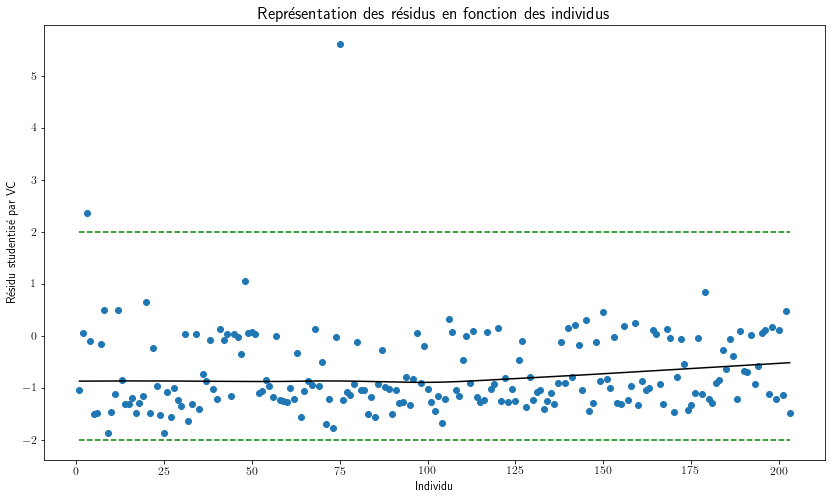

In [108]:
## Résidu studentisé
n = len(X)


from statsmodels.nonparametric.smoothers_lowess import lowess # pour le lissage
from statsmodels.stats.outliers_influence import OLSInfluence # pour récupérer les résidus studentisés

influ = OLSInfluence(model1)
x = np.linspace(1,n,n)
y = np.repeat(2,n)
fig, ax = plt.subplots()

ax.scatter(x,influ.resid_studentized_external)
ax.plot(x,y,linestyle='dashed',color='green')
ax.plot(x,-y,linestyle='dashed',color='green')

filtered = lowess(influ.resid_studentized_external,x)
ax.plot(filtered[:,0],filtered[:,1],color='black')
ax.set_xlabel("Individu")
ax.set_ylabel("Résidu studentisé par VC")
ax.set_title("Représentation des résidus en fonction des individus") 

In [109]:
## Observation des aberrants
outliers = X.iloc[np.where(np.abs(influ.resid_studentized_external) > 2)].index
#outliers
#X.iloc[outliers]

## Modèle explicatif 2
C'est un modèle sans les outliers.

In [110]:
X = base_finale[variables_lineare].drop(outliers, axis=0)
Y = base_finale[variable_expliquee].drop(outliers, axis=0)
#X = sm.add_constant(X)

model2 = sm.OLS(Y,X).fit()
print(model2.summary())

                                 OLS Regression Results                                
Dep. Variable:               ges_rate   R-squared (uncentered):                   0.462
Model:                            OLS   Adj. R-squared (uncentered):              0.445
Method:                 Least Squares   F-statistic:                              27.91
Date:                Mon, 02 May 2022   Prob (F-statistic):                    6.05e-24
Time:                        00:16:36   Log-Likelihood:                         -762.13
No. Observations:                 201   AIC:                                      1536.
Df Residuals:                     195   BIC:                                      1556.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

### Normalité des résidus

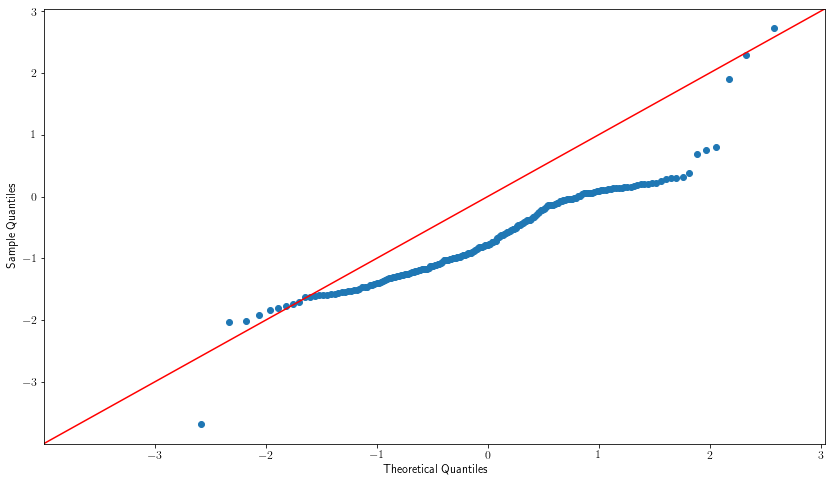

In [111]:
influ2 = OLSInfluence(model2)
fig = sm.qqplot(influ2.resid_studentized_external,line='45')

Text(0, 0.5, 'Résidus studentisés')

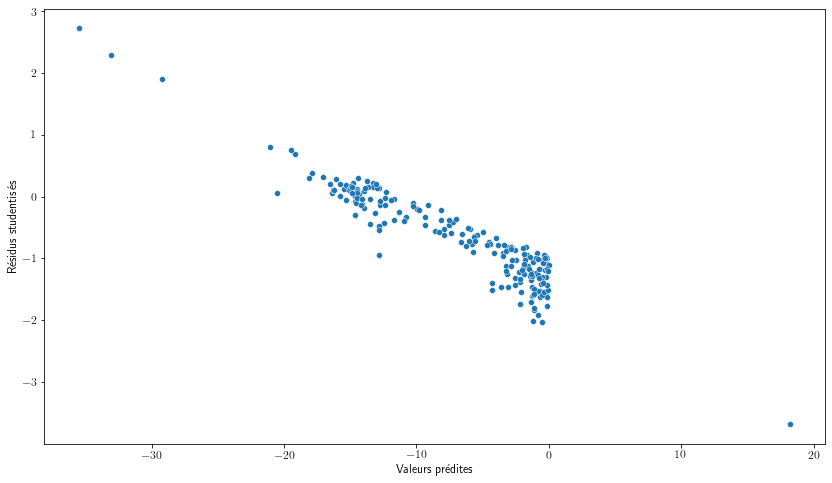

In [112]:
## Nuage des résidus
plt.figure()
ax = sns.scatterplot(model2.fittedvalues, influ2.resid_studentized_external)
ax.set_xlabel('Valeurs prédites')
ax.set_ylabel('Résidus studentisés')

## Modèle explicatif 3

In [113]:
X = base_finale[variables_lineare_aic]
Y = base_finale[variable_expliquee]
#X = sm.add_constant(X)

model2 = sm.OLS(Y,X).fit()
print(model2.summary())

                                 OLS Regression Results                                
Dep. Variable:               ges_rate   R-squared (uncentered):                   0.753
Model:                            OLS   Adj. R-squared (uncentered):              0.745
Method:                 Least Squares   F-statistic:                              99.96
Date:                Mon, 02 May 2022   Prob (F-statistic):                    4.80e-57
Time:                        00:16:37   Log-Likelihood:                         -690.63
No. Observations:                 203   AIC:                                      1393.
Df Residuals:                     197   BIC:                                      1413.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

## Modèle explicatif 4
C'est un modèle sur les ratios uniquement.

In [114]:
X = base_finale[[col for col in base_finale if ('_rate' in col) & (col != 'ges_rate')]]
Y = base_finale[variable_expliquee]
#X = sm.add_constant(X)

model3 = sm.OLS(Y,X).fit()
print(model3.summary())

                                 OLS Regression Results                                
Dep. Variable:               ges_rate   R-squared (uncentered):                   0.345
Model:                            OLS   Adj. R-squared (uncentered):              0.318
Method:                 Least Squares   F-statistic:                              12.81
Date:                Mon, 02 May 2022   Prob (F-statistic):                    9.28e-15
Time:                        00:16:37   Log-Likelihood:                         -789.59
No. Observations:                 203   AIC:                                      1595.
Df Residuals:                     195   BIC:                                      1622.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

# 4. Modélisation prédictive

Nous proposons de tester les modèles linéaires (multiple, ridge, lasso) et les modèles d'arbres de régression et forêts aléatoires. Le choix de ces modèles s'explique par leur simplicité à l'interprétation, laquelle nous évite de s'éloigner de l'approche top-down. <p>
Nous réalisons une transformation polynomiale pour élargir le champ des paramètres à optimiser.

In [115]:
# Création des modèles de travail
lm = make_pipeline(PolynomialFeatures(), LinearRegression())
ridge = make_pipeline(PolynomialFeatures(), Ridge())
lasso = make_pipeline(PolynomialFeatures(), Lasso())
elasticNet = make_pipeline(PolynomialFeatures(), ElasticNet())
dtr = make_pipeline(PolynomialFeatures(), DecisionTreeRegressor())
rfr = make_pipeline(PolynomialFeatures(), RandomForestRegressor())


La fonction de coût est l'erreur quadratique moyenne, vu que la variable explicative est quantitative.

In [116]:
# Définition de paramètre de transformation
param ={'polynomialfeatures__degree':[1]}#[1,2,3,4]}

## Création des GridSearch pour l'optimisation des paramètres
lm_g = GridSearchCV(lm, param, cv=5, scoring='neg_mean_squared_error')
ridge_g = GridSearchCV(ridge, param, cv=5, scoring='neg_mean_squared_error')
lasso_g = GridSearchCV(lasso, param, cv=5, scoring='neg_mean_squared_error')
elasticNet_g = GridSearchCV(elasticNet, param, cv=5, scoring='neg_mean_squared_error')
dtr_g = GridSearchCV(dtr, param, cv=4, scoring='neg_mean_squared_error')
rfr_g = GridSearchCV(rfr, param, cv=4, scoring='neg_mean_squared_error')


In [117]:
ridge_g.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001))],
                                verbose=False),
             iid='warn', n_jobs=None,
        

In [118]:
# Défintion d'une dictionnaire des modèles
dico_modeles = {'Régresssion linéaire': lm_g,
                'Régression Lasso': lasso_g,
                'Régression ridge': ridge_g,
                'ElasticNet':elasticNet_g,
                'Arbre de régression':dtr_g,
                'Foret aléatoire': rfr_g}

#### Création d'échantillons d'apprentissage et test

Nous proposons de faire 80% e échan. apprentissage et 20% en échan. test comme recommander dans nombreuses études

In [119]:
# Division de la base en apprentissage et test
x_train, x_test, y_train, y_test = train_test_split(base_finale[variables_lineare_aic],
base_finale['ges_rate'], test_size = 0.2, random_state = 2022)

In [120]:
# Division de la base en apprentissage et test
x_train, x_test, y_train, y_test = train_test_split(base_finale[variables_lineare],
base_finale['ges_rate'], test_size = 0.2, random_state = 2022)


In [121]:
## Exécution des modèles
lm_g.fit(x_train, y_train)
lasso_g.fit(x_train, y_train)
ridge_g.fit(x_train, y_train)
elasticNet_g.fit(x_train, y_train)
dtr_g.fit(x_train, y_train)
rfr_g.fit(x_train, y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('randomforestregressor',
                                        RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              min_impurit

## Evaluation des différents modèles

La prémière évaluation ressort l'ajustement linéaire des valeurs prédictives avec les vraies valeurs de l'échantillon test. Elle founit également la durée d'exécution de chaque modèle.

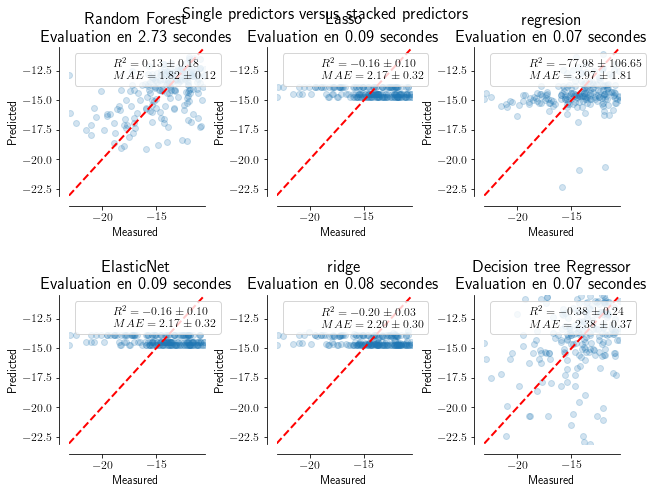

In [122]:
estimators = [
    ("Random Forest", rfr_g),
    ("Lasso", lasso_g),
    ("regresion", lm_g),
    ("ElasticNet", elasticNet_g),
    ("ridge", ridge_g)
]

def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "--r", linewidth=2
    )
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0
    )
    ax.legend([extra], [scores], loc="upper left")
    title = title + "\n Evaluation en {:.2f} secondes".format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(2, 3, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators + [("Decision tree Regressor", dtr_g)]
):
    start_time = time.time()
    score = cross_validate(
        est, X, Y, scoring=["r2", "neg_mean_absolute_error"], n_jobs=2, verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, Y, n_jobs=2, verbose=0)

    plot_regression_results(
        ax,
        Y,
        y_pred,
        name,
        (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
            np.mean(score["test_r2"]),
            np.std(score["test_r2"]),
            -np.mean(score["test_neg_mean_absolute_error"]),
            np.std(score["test_neg_mean_absolute_error"]),
        ),
        elapsed_time,
    )

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


## Evaluation erreur de prédiction et surapprentissage
On évalue également les modèles à partir de l'erreur quadratique moyenne et de la courbe d'apprentissage.

In [123]:
# Fonction d'évaluation
def evaluation(model, titre):
    print('+===================================================+')
    print(titre)
    y_pred = model.predict(x_test)
    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.plot([np.min(y_test), 0.001, np.max(y_test)], [np.min(y_test), 0.001, np.max(y_test)], 'r-', lw=1)
    
    print("MSE: ", mean_squared_error(y_test, y_pred))
    
    N, train_score, val_score = learning_curve(model, x_train, y_train, cv=4, 
    scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1,1,5))
    plt.figure()
    plt.title(titre, size=16)
    plt.plot(N, train_score.mean(axis =1), label = 'train')
    plt.plot(N, val_score.mean(axis =1), label = 'validation')
    plt.xlabel('Nombre d\'observations')
    plt.ylabel('Négtive de l\'EQM')
    plt.legend()

## Choix de meilleurs modèles

+===================================================+
Régression
MSE:  9.989476304094287
None


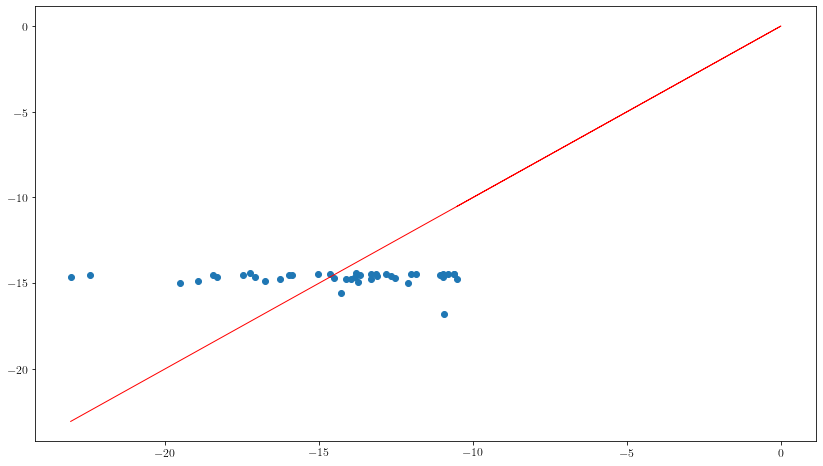

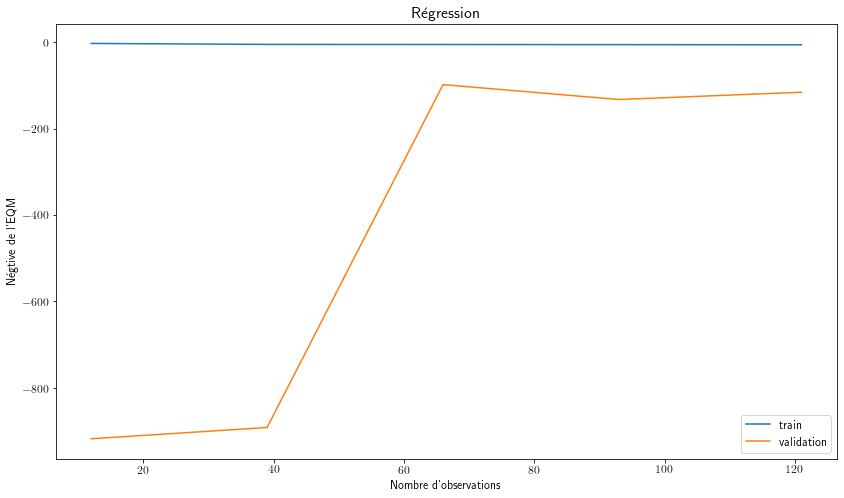

In [124]:
print(evaluation(lm_g, 'Régression'))

+===================================================+
Régression Lasso
MSE:  9.600027413143625
None


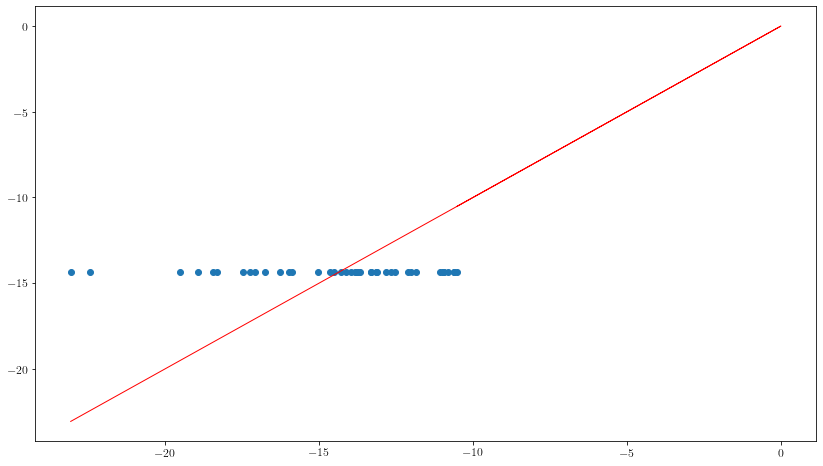

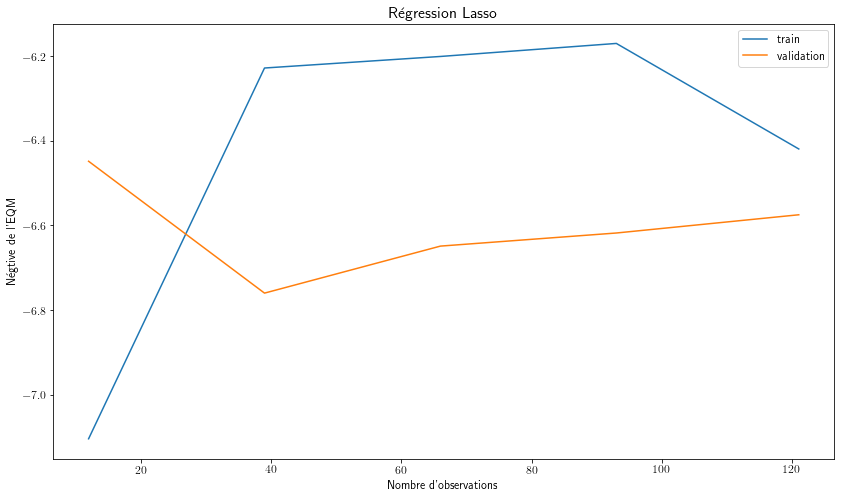

In [125]:
print(evaluation(lasso_g, 'Régression Lasso'))

+===================================================+
Régression ridge
MSE:  9.528543401903407
None


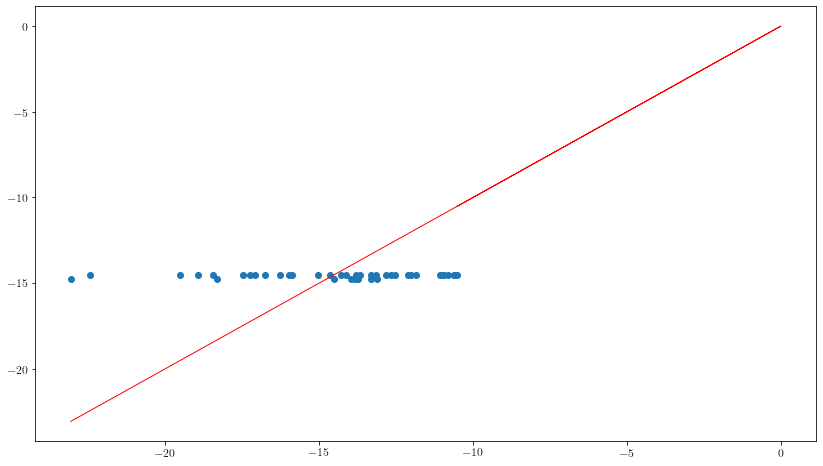

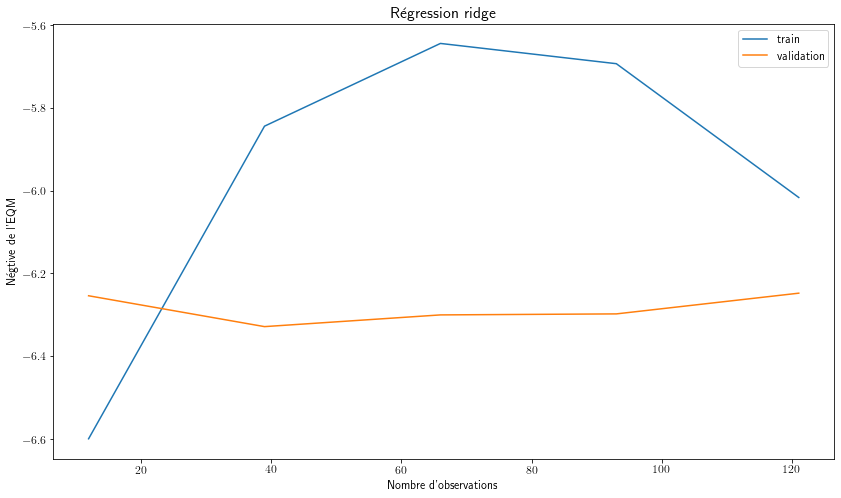

In [126]:
print(evaluation(ridge_g, 'Régression ridge'))

+===================================================+
Elastic Net
MSE:  9.600027413143625
None


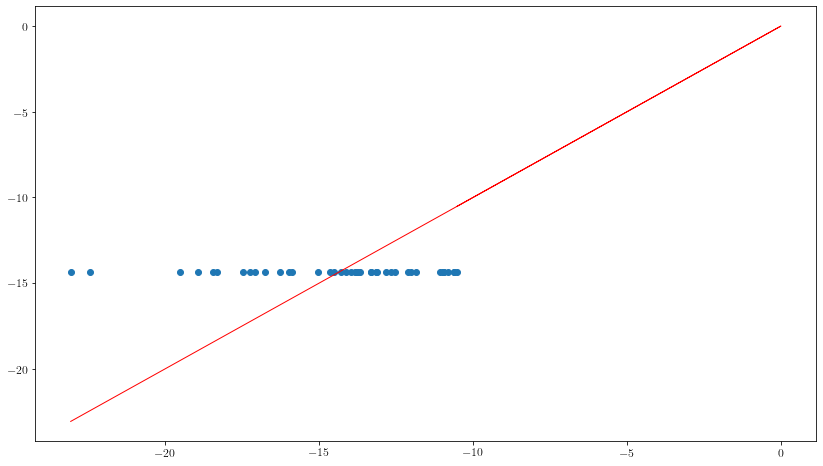

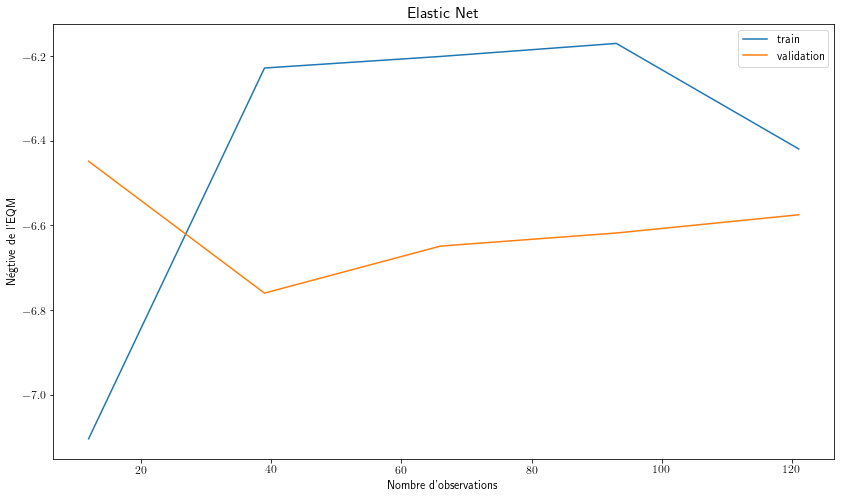

In [127]:
print(evaluation(elasticNet_g, 'Elastic Net'))

+===================================================+
Abre de régression
MSE:  11.981229922151508
None


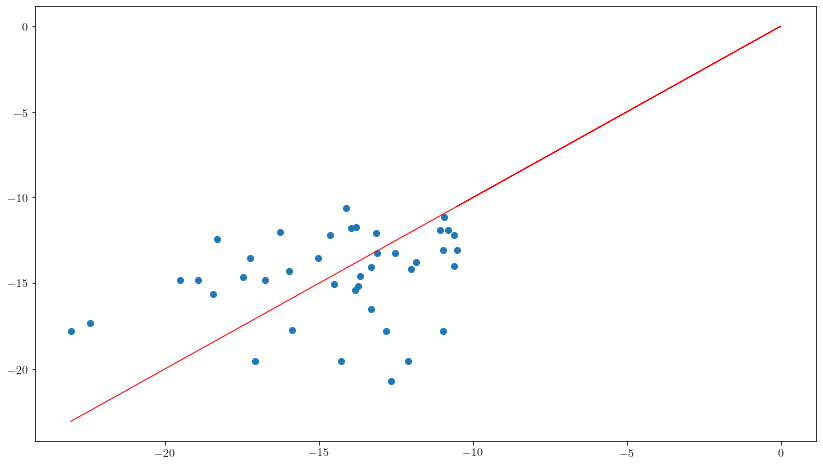

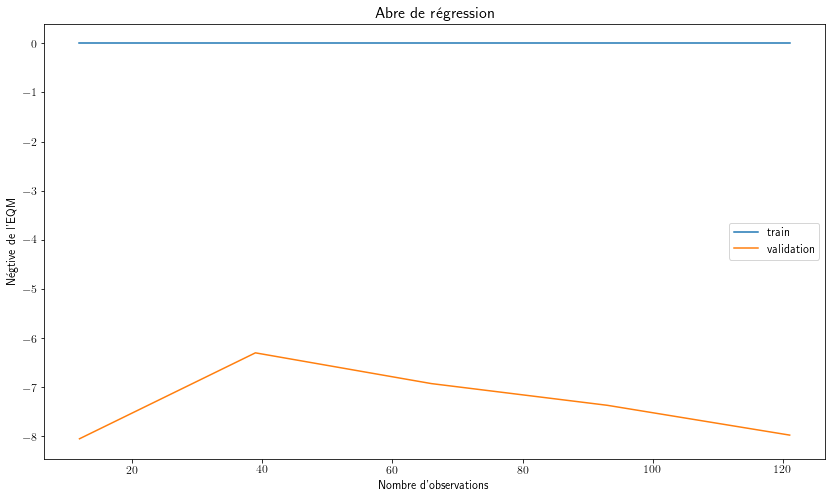

In [128]:
print(evaluation(dtr_g, 'Abre de régression'))

+===================================================+
Random Forest
MSE:  7.516863713127472
None


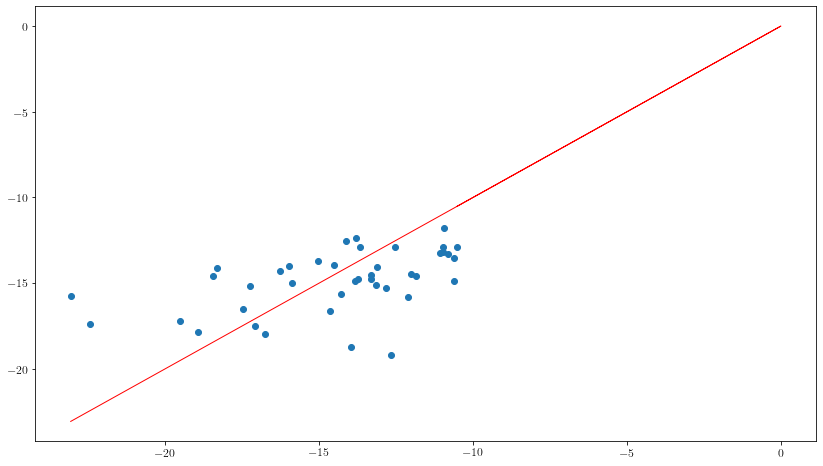

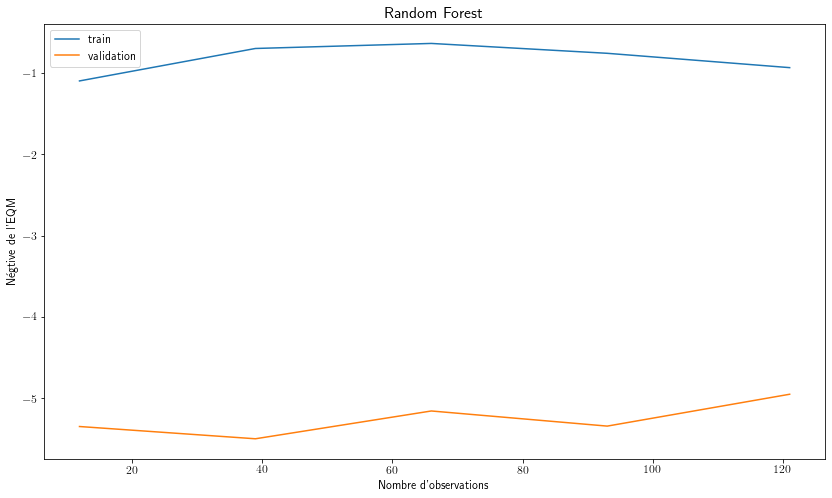

In [129]:
print(evaluation(rfr_g, 'Random Forest'))

### A l'issu de l'évaluation des modèles, celui ainsi choisi est la régression ridge.

In [130]:
ridge_g.best_params_

{'polynomialfeatures__degree': 1}

 Essayons d'expliquer ce modèle à l'aide d'outils de régression

In [131]:
## Variables explicatives du modèle
variables_lineare

['CA_rate',
 'NbEmploye_rate',
 'CA_export_rate',
 'construction',
 'dechets',
 'indus_manu']

### Description du modèle retenu

#### Coef du modèle

In [132]:
best_model = Ridge(alpha=1.0, fit_intercept= False)
best_model.fit(x_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [133]:
best_model.coef_
#stats.summary(best_model, x_train, y_train)

array([ -0.15213927,  -0.18880176,  -0.12063887, -12.23998179,
       -10.1411322 , -14.25748297])

### Enregistrement des résultats pour la comparaison au modèle classique

In [134]:
ok = ridge_g.predict(x_test)
df = pd.DataFrame(
    {
    'y_true_r': y_test,
    'y_pred': ok
    }
)
df["mse_ratio"] = (df.y_true_r - df.y_pred)**2
print("===================================\n mse_ratio\n", np.mean(df["mse_ratio"]), " et ",
    "IC à 95: [",np.mean(df["mse_ratio"]) - 1.96*np.std(df["mse_ratio"])/np.sqrt(df.shape[0]),
    ", ",np.mean(df["mse_ratio"]) + 1.96*np.std(df["mse_ratio"])/np.sqrt(df.shape[0]),"] \n")

df.to_csv("bdd/Base_finale/temp_comparaison.csv", index =  False)

 mse_ratio
 9.52854340190341  et  IC à 95: [ 5.166428350407323 ,  13.890658453399496 ] 

